# Calibration: frequency to resistance

## Hardware used
  
  A single build `Resistive AC soil moisture sensor v1.0`
  PCB connected to an Adafruit ItsyBitsy 32u4 microcontroller
  board flashed with the following code found at:
  https://github.com/Dennis-van-Gils/PCB-resistive-AC-soil-moisture-sensor/tree/main/src_mcu

## Calibration procedure
  I apply a known resistance `R[Ohm]` over the probe terminals
  and measure the resulting frequency `f[Hz]`. I then perform
  a non-linear least-squares fit to the data to be able to
  transform the output frequency back to a resistance.

## Used fit
  The `log10(f)` vs `log10(R)` curve can be captured by an S-curve
  rotated by 90 degrees, also known as a `logit` function
  (https://en.wikipedia.org/wiki/Logit):
    
    logit(p) = ln(p / (1 - p)), for 0 < p < 1
  
  I add 4 fitting parameters `k`, `x0`, `b` and `a` to the
  logit function to be able to fit the data. Hence, what we
  end up with is the following C++ code to transform measured
  frequency [Hz] into resistance [Ohm]:
  
    double p = (log10(frequency) - x0) * b;
    double R_log = (k * log(p / (1 - p)) + a);
    resistance = pow(10, R_log);
    
  The fit is inherently monotonic.
    
## Calibration results
  In this specific realization I found the following best
  fit results, leading to a resistance fitting accuracy of
  +/-20 % (at worst). It is good enough for order-of-10s
  estimation over the range 10 Ohm to 10 MOhm.
  
    const double k  = -0.61404261;
    const double x0 = 1.65479988;
    const double b  = 0.40044114;
    const double a  = 3.97842502;
    
Dennis van Gils, 19-05-2022

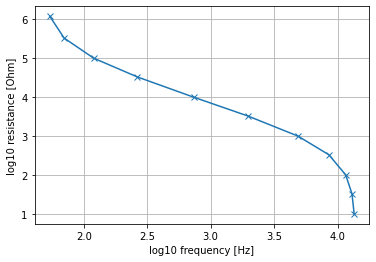

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Applied a known resistance R[Ohm] and measured the resulting frequency f[Hz]
R = np.array([0.1, 10, 33, 100, 330, 1000, 3300, 10000, 33000, 100000, 330000, 1200000, 100000000])
f = np.array([13755, 13513, 12987, 11600, 8554, 4873, 1955, 734, 265, 120, 70, 54, 48])

# Fit becomes better when we remove the outer points
R = R[1:-1]
f = f[1:-1]

# Plot
R_log = np.log10(R)
f_log = np.log10(f)
plt.plot(f_log, R_log, 'x-')
plt.xlabel('log10 frequency [Hz]')
plt.ylabel('log10 resistance [Ohm]')
plt.grid()
plt.show()

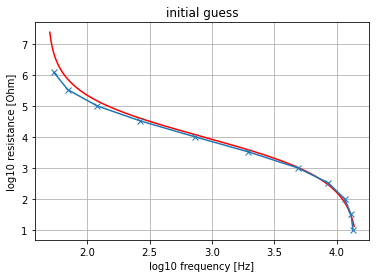

In [2]:
def logit_fun(x, k, x0, b, a):
    # The log10(frequency)-log10(resistance) curve can be captured by
    # a `logit()` function, where
    # logit(p) = ln(p / (1 - p)), for 0 < p < 1
    p = (x - x0) * b
    p = list(map(lambda x: np.nan if ((x <= 0) or (x >= 1)) else x, p))
    p = np.array(p)
    return (k * np.log(p / (1 - p)) + a)    

# Manually search for a reasonable fit to act as an initial guess
# for the upcoming non-linear least-squares fitting procedure
p0 = [-0.7, 1.68, 0.4, 4]  # Initial guess
x = np.linspace(1.7, 4.14, 501)
y = logit_fun(x, *p0)

plt.plot(x, y, 'r')
plt.plot(f_log, R_log, 'x-')
plt.title('initial guess')
plt.xlabel('log10 frequency [Hz]')
plt.ylabel('log10 resistance [Ohm]')
plt.grid()
plt.show()

In [3]:
# Non-linear least-squares fitting
from scipy.optimize import curve_fit
popt, pcov = curve_fit(logit_fun, f_log, R_log, p0, method='lm')
print(popt)  # Optimal best-fit result: [k, x0, b, a]

[-0.61404261  1.65479988  0.40044114  3.97842502]


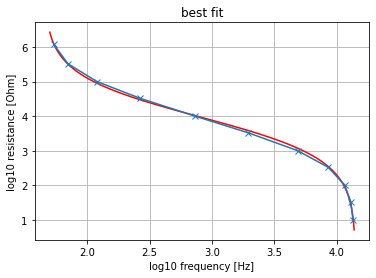

In [4]:
y_fit = logit_fun(x, *popt)
plt.plot(x, y_fit, 'r')
plt.plot(f_log, R_log, 'x-')
plt.title('best fit')
plt.xlabel('log10 frequency [Hz]')
plt.ylabel('log10 resistance [Ohm]')
plt.grid()
plt.show()

In [5]:
# Show fitting residuals and deviation
R_fit = 10**(logit_fun(f_log, *popt))
R_residuals = R_fit - R

print("%8s%12s%12s%10s%9s" % ("f [Hz]", "R [Ω]", "R_fit [Ω]", "res [Ω]", "dev [%]"))
for idx, value in enumerate(R_fit):
    print("%8.0f%12.0f%12.0f%10.0f%9.0f" % (f[idx], R[idx], R_fit[idx], R_residuals[idx], R_residuals[idx]/R[idx]*100))

  f [Hz]       R [Ω]   R_fit [Ω]   res [Ω]  dev [%]
   13513          10          11         1       14
   12987          33          27        -6      -19
   11600         100          88       -12      -12
    8554         330         349        19        6
    4873        1000        1179       179       18
    1955        3300        3838       538       16
     734       10000       10364       364        4
     265       33000       29943     -3057       -9
     120      100000       89605    -10395      -10
      70      330000      323978     -6022       -2
      54     1200000     1232152     32152        3
